In [1]:
#Import Necessary Libraries
from os import listdir
from pickle import dump
from keras.applications.vgg16 import VGG16
from keras_preprocessing.image import load_img
from keras_preprocessing.image import img_to_array
from keras.applications.resnet import preprocess_input
from keras.models import Model

In [2]:
#extracted all necessary information and stored it into text file
import json
c =0 
with open('dataset.json','r') as json_data:
    data = json.load(json_data)
    for d in data['images']:
        for di in d['sentences']:
            fo = open('ucm_text/ucm_tokens.txt','a')
            fo.write(d['filename']+'#'+str(c)+'   '+di.get('raw')+'\n')
            c+=1
        c=0
        fo.close()

In [11]:
# from keras.utils import plot_model
# model = ResNet50()
# model.layers.pop()
# # re-structure the model
# model= Model(inputs=model.input, outputs=model.layers[-1].output)
# plot_model(model, rankdir= "LR")


In [3]:
# extract features from each photo in the directory
def extract_features(directory):
	# load the model
	model = VGG16()
	model.layers.pop()
	# re-structure the model
	model= Model(inputs=model.input, outputs=model.layers[-2].output)
	print(model.summary())
	# extract features from each photo
	features = dict()
	for name in listdir(directory):
		# load an image from file
		filename = directory + '/' + name
		image = load_img(filename, target_size=(224, 224))
		# convert the image pixels to a numpy array
		image = img_to_array(image)
		# reshape data for the model
		image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
		# prepare the image for the VGG model
		image = preprocess_input(image)
		# get features
		feature = model.predict(image, verbose=0)
		# get image id
		image_id = name.split('.')[0]
		# store feature
		features[image_id] = feature
		print('>%s' % name)
	return features

# extract features from all images
directory = 'imgs'
features = extract_features(directory)
print('Extracted Features: %d' % len(features))
# save to file
dump(features, open('image_features.pkl', 'wb'))


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# model = Model(inputs=model.inputs , outputs=model.output)

In [ ]:
# from tensorflow.keras.preprocessing.image import load_img, img_to_array
# from tensorflow.keras.applications.vgg16 import preprocess_input

# image = load_img("drive/MyDrive/mini_proj/image_captioning/RSICD_images/viaduct_28.jpg", target_size=(224, 224))

# image = img_to_array(image)
# image = np.expand_dims(image, axis=0)
# image = preprocess_input(image)

1/1 [==============================] - 0s 72ms/step


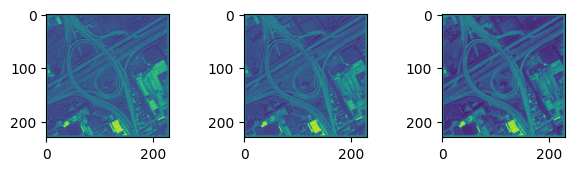

In [ ]:
# import numpy as np
# from tensorflow.keras.preprocessing.image import load_img, img_to_array
# from tensorflow.keras.applications.vgg16 import preprocess_input
# import matplotlib.pyplot as plt

# # Assuming you have already defined and compiled the 'model'

# image = load_img("drive/MyDrive/mini_proj/image_captioning/RSICD_images/viaduct_28.jpg", target_size=(224, 224))
# image = img_to_array(image)
# image = np.expand_dims(image, axis=0)
# image = preprocess_input(image)

# features = model.predict(image)
# fig = plt.figure(figsize=(20, 15))
# columns = 8
# rows = 8
# n_filters = columns * rows

# for i in range(1, n_filters + 1):
#     if i <= features.shape[3]:  # Check if index is within bounds
#         plt.subplot(rows, columns, i)
#         plt.imshow(features[0, :, :, i - 1])
#     else:
#         break  # Break the loop if index is out of bounds

# plt.show()


In [4]:
# load doc into memory
def document_load(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	capts = file.read()
	# close the file
	file.close()
	return capts

# filename = 'Flickr8k_text/Flickr8k.token.txt'
filename = 'ucm_text/ucm_tokens.txt'
# load descriptions
document = document_load(filename)

In [5]:
# extract descriptions for images
def load_captions(document):
	mapping = dict()
	# process lines
	for imgcapt in document.split('\n'):
		# split line by white space
		tokens = imgcapt.split()
		if len(imgcapt) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_caption = tokens[0], tokens[1:]
		# remove filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_caption = ' '.join(image_caption)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_caption)
	return mapping

# parse descriptions
captions = load_captions(document)
print('Loaded: %d ' % len(captions))

Loaded: 2100 


In [6]:
import string

def clean_captions(captions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for id, capt_list in captions.items():
		for i in range(len(capt_list)):
			capt = capt_list[i]
			# tokenize
			capt = capt.split()
			# convert to lower case
			capt = [word.lower() for word in capt]
			# remove punctuation from each token
			capt = [w.translate(table) for w in capt]
			# remove hanging 's' and 'a'
			capt = [word for word in capt if len(word)>1]
			# remove tokens with numbers in them
			capt = [word for word in capt if word.isalpha()]
			# store as string
			capt_list[i] =  ' '.join(capt)

# clean descriptions
clean_captions(captions)

In [7]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(captions):
	# build a list of all description strings
	all_desc = set()
	for key in captions.keys():
		[all_desc.update(d.split()) for d in captions[key]]
	return all_desc

# summarize vocabulary
vocab = to_vocabulary(captions)
print('Vocabulary Size: %d' % len(vocab))

Vocabulary Size: 333


In [8]:
# save descriptions to file, one per line
def save_captions(captions, filename):
	lines = list()
	for key, desc_list in captions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

# save to file
save_captions(captions, 'captions.txt')

In [9]:
def save_image_id(captions, filename):
	lines = list()
	for key, desc_list in captions.items():
		lines.append(key+'.tif')
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

# save to file
save_image_id(captions, 'ucm_text/image_id.txt')

In [10]:
import numpy as np
id_list = np.loadtxt("ucm_text/image_id.txt",dtype="str")
print(id_list)

['1.tif' '2.tif' '3.tif' ... '2098.tif' '2099.tif' '2100.tif']


In [11]:
from sklearn.model_selection import train_test_split

training_data, testing_data = train_test_split(id_list, test_size=0.2, random_state=0)


In [12]:
data = '\n'.join(training_data)
file = open('ucm_text/train_images_id.txt', 'w')
file.write(data)
file.close()

In [13]:
data = '\n'.join(testing_data)
file = open('ucm_text/test_images_id.txt', 'w')
file.write(data)
file.close()

In [14]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = document_load(filename)
	train_dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		train_dataset.append(identifier)
	return set(train_dataset)

filename = 'ucm_text/train_images_id.txt'
train_dataset = load_set(filename)
print('Dataset: %d' % len(train_dataset))

Dataset: 1680


In [15]:
# load clean descriptions into memory
def load_clean_descriptions(filename, train_dataset):
	# load document
	document = document_load(filename)
	descriptions = dict()
	for imgcapt in document.split('\n'):
		# split line by white space
		tokens = imgcapt.split()
		# split id from description
		image_id, image_caption = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in train_dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_caption) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions('captions.txt', train_dataset)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=1680


In [16]:
from pickle import load

# load photo features
def load_image_features(filename, dataset):
	# load all features
	all_features = load(open(filename, 'rb'))
	# filter features
	features = {k: all_features[k] for k in dataset}
	return features

# photo features
train_features = load_image_features('image_features.pkl', train_dataset)
print('Photos: train=%d' % len(train_features))
train_descriptions

Photos: train=1680


{'1': ['startseq there is piece of farmland endseq',
  'startseq there is piece of cropland endseq',
  'startseq it is piece of farmland endseq',
  'startseq it is piece of cropland endseq',
  'startseq here is piece of farmland endseq'],
 '2': ['startseq there is piece of farmland endseq',
  'startseq there is piece of cropland endseq',
  'startseq it is piece of farmland endseq',
  'startseq it is piece of cropland endseq',
  'startseq here is piece of farmland endseq'],
 '3': ['startseq there is piece of farmland endseq',
  'startseq there is piece of cropland endseq',
  'startseq it is piece of farmland endseq',
  'startseq it is piece of cropland endseq',
  'startseq here is piece of farmland endseq'],
 '4': ['startseq there is piece of farmland endseq',
  'startseq there is piece of cropland endseq',
  'startseq it is piece of farmland endseq',
  'startseq it is piece of cropland endseq',
  'startseq here is piece of farmland endseq'],
 '5': ['startseq there is piece of farmland 

In [17]:
from numpy import array
import tensorflow
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import add
from keras.callbacks import ModelCheckpoint

In [18]:
# covert a dictionary of clean descriptions to a list of descriptions
def to_list(captions):
	all_capt = list()
	for key in captions.keys():
		[all_capt.append(d) for d in captions[key]]
	return all_capt

In [19]:
def create_tokenizer(descriptions):
	lines = to_list(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# get vocabulary size
tokenizer = create_tokenizer(train_descriptions)
print(tokenizer)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 331


In [20]:
def max_length(captions):
	lines = to_list(captions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 23


In [21]:
def create_sequences(tokenizer, max_length, desc_list, photo):
	X1, X2, y = list(), list(), list()
	# walk through each description for the image
	for desc in desc_list:
		# encode the sequence
		seq = tokenizer.texts_to_sequences([desc])[0]
		# split one sequence into multiple X,y pairs
		for i in range(1, len(seq)):
			# split into input and output pair
			in_seq, out_seq = seq[:i], seq[i]
			# pad input sequence
			in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
			# encode output sequence
			out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
			# store
			X1.append(photo)
			X2.append(in_seq)
			y.append(out_seq)
	return array(X1), array(X2), array(y)

In [22]:
import keras

In [23]:
from keras.layers import *
from keras.models import Model

In [24]:
#defining learning rate
opt = keras.optimizers.Adam(learning_rate=0.0001)

In [25]:
from keras.layers import *
from keras.models import Model

def define_model(vocab_size, max_length):
    # feature extractor model
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    print(fe2.shape)

    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    print(se2.shape)

    # Add soft attention mechanism
    attention = dot([fe2, se2], axes=[1, 2])
    attention = Activation('softmax')(attention)
    context = dot([attention, se2], axes=[1, 1])
    
    # LSTM layer with the context vector
    se3 = LSTM(256, return_sequences=True)(Reshape((1, 256))(context))  # Add the return_sequences argument
    se3 = Flatten()(se3)  # Flatten the output to make it 2D
    
    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer=opt)
    
    # summarize model
    model.summary()
    return model


In [26]:
#Below code is used to progressively load the batch of data
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, tokenizer, max_length):
	# loop for ever over images
	while 1:
		for key, desc_list in descriptions.items():
			# retrieve the photo feature
			photo = photos[key][0]
			in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo)
			yield [[in_img, in_seq], out_word]

In [46]:
pip install graphviz 


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
# train the model
model = define_model(vocab_size, max_length)
# train the model, run epochs manually and save after each epoch
epochs = 500
steps = len(train_descriptions)
for i in range(epochs):
	# create the data generator
	generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
	# fit for one epoch
	history=model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1, batch_size=10)
	# save model
	model.save('Models/model_' + str(i) + '.h5')

(None, 256)
(None, 23, 256)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 4096)]               0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 23)]                 0         []                            
                                                                                                  
 dropout (Dropout)           (None, 4096)                 0         ['input_2[0][0]']             
                                                                                                  
 embedding (Embedding)       (None, 23, 256)              84736     ['input_3[0][0]']             
                                                                

c:\Users\ankit\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1680/1680 [==============================] - 52s 31ms/step - loss: 0.3862


In [ ]:
# history = history.keys()
# keys=history.history.keys()
# loss_values = history.history['loss']


NameError: name 'model' is not defined

In [ ]:
# import matplotlib.pyplot as plt

# plt.plot(history.history['loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train'],loc="upper left")
# plt.show()


import matplotlib.pyplot as plt

plt.plot(loss_values)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train'], loc="upper left")
plt.show()

NameError: name 'loss_values' is not defined

In [28]:
from numpy import argmax
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

In [29]:
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

In [30]:
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text

In [31]:
# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	# step over the whole set
	for key, desc_list in descriptions.items():
		# generate description
		yhat = generate_desc(model, tokenizer, photos[key], max_length)
		# store actual and predicted
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [32]:
# prepare test set

# load test set
filename = 'ucm_text/test_images_id.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('captions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_image_features('image_features.pkl', test)
print('Photos: test=%d' % len(test_features))

# load the model which has minimum loss, in this case it was model_19
filename = 'Models/model_499.h5'
model = load_model(filename)
# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

Dataset: 420
Descriptions: test=420
Photos: test=420
BLEU-1: 0.786294
BLEU-2: 0.723308
BLEU-3: 0.703659
BLEU-4: 0.637748


In [ ]:
max_length = 34
# load the model
model = load_model('Models/model_34.h5')

In [ ]:
def load_image_feature(filename, image):
	# load all features
	all_features = load(open(filename, 'rb'))
	# filter features
	features = all_features[image]
	return features

In [ ]:

image_id = '531'
photo = load_image_feature('image_features.pkl',image_id)
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

NameError: name 'load' is not defined

In [ ]:
image_id = 'square_193'
photo = load_image_feature('image_features.pkl',image_id)
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

In [ ]:
image_id = 'center_102'
photo = load_image_feature('image_features.pkl',image_id)
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

KeyError: 'center_102'

In [ ]:
image_id = 'stadium_78'
photo = load_image_feature('image_features.pkl',image_id)
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

In [ ]:
image_id = 'stadium_78'
photo = load_image_feature('image_features.pkl',image_id)
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

In [ ]:
image_id = 'beach_182'
photo = load_image_feature('image_features.pkl',image_id)
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

In [ ]:
image_id = 'railwaystation_173'
photo = load_image_feature('image_features.pkl',image_id)
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

In [ ]:
image_id = 'airport_230'
photo = load_image_feature('image_features.pkl',image_id)
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

In [ ]:
image_id = 'beach_23'
photo = load_image_feature('image_features.pkl',image_id)
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

In [ ]:
photo = extract_features('RSICD_images/beach_23.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

In [ ]:
photo = extract_features('RSICD_images/center_102.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

In [ ]:
photo = extract_features('RSICD_images/beach_2.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

In [ ]:
config = tensorflow.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tensorflow.compat.v1.Session(config=config)

In [ ]:
photo = extract_features('RSICD_images/airport_230.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

In [ ]:
photo = extract_features('RSICD_images/stadium_78.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

In [ ]:
photo = extract_features('RSICD_images/park_33.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

In [ ]:
photo = extract_features('RSICD_images/stadium_197.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

In [ ]:
photo = extract_features('RSICD_images/airport_137.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

In [ ]:
photo = extract_features('RSICD_images/airport_174.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

In [ ]:
photo = extract_features('RSICD_images/viaduct_292.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

In [ ]:
photo = extract_features('RSICD_images/denseresidential_120.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

ValueError: ignored

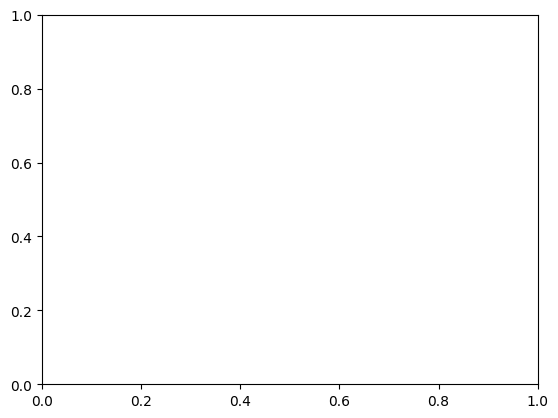

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
losses = [2.34, 1.98, 1.65, 1.44, 1.31, 1.21, 1.13, 1.06, 1.00, 0.95, 0.90, 0.86, 0.82, 0.79, 0.76, 0.73, 0.70, 0.68, 0.66, 0.63, 0.61, 0.59, 0.57, 0.56, 0.54, 0.52, 0.51, 0.49, 0.48, 0.47, 0.45, 0.44, 0.43, 0.42, 0.41, 0.40, 0.39, 0.38, 0.37, 0.36, 0.35, 0.34, 0.33, 0.32, 0.31, 0.30, 0.29, 0.28, 0.27, 0.26, 0.25, 0.24, 0.23]

epochs_arr = np.array(epochs)
losses_arr = np.array(losses)


# assume you have two numpy arrays named epochs and loss
plt.plot(epochs_arr, losses_arr)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epoch')
plt.show()